In [1]:
!pip install git+https://github.com/rwalk/gsdmm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-z43hs_m4
  Running command git clone --filter=blob:none --quiet https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-z43hs_m4
  Resolved https://github.com/rwalk/gsdmm.git to commit 4ad1b6b6976743681ee4976b4573463d359214ee
  Preparing metadata (setup.py) ... done
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4603 sha256=5f06e98bacfb003b06464b024637331587819781d5e804effccc39a71cb5c5da
  Stored in directory: /tmp/pip-ephem-wheel-cache-cp7r7q7g/wheels/81/2c/23/3ff788bcc6063bf30116ad1a06e75d3ba9aad3f7bc4aba765b
Successfully built gsdmm


In [2]:
import numpy as np 
import pandas as pd

import sys
#sys.path.append('../input/gsdmm-short-text-clustering')
from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re


from gensim.models import Phrases
from gensim.models.phrases import Phraser

import os


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
"""for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [4]:
data = pd.read_excel('/content/drive/MyDrive/invisalignKeyword_raw.xlsx')
data.head()

,SubmissionNumber,Content
0,1,Did any of you ever get used to the feeling of...
1,2,Started with metal braces and after a month of...
2,3,Invisalign vs ceramic braces... Which would yo...
3,4,How long do you leave your braces off to eat?I...
4,5,Im only wearing my Invisalign 10-14hrs a day. ...


In [5]:
data['length'] = data.Content.apply(lambda row: len(row.split()))
print('Mean length: ', data['length'].mean())

Mean length:  76.29718004338395


<ipython-input-6-2fe51070bcf8>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['length'])


<Axes: xlabel='length', ylabel='Density'>

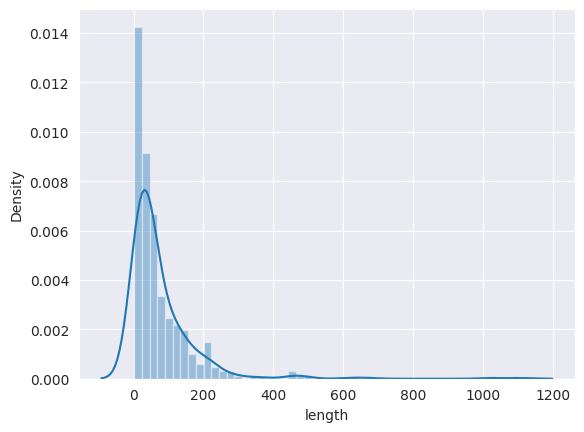

In [6]:
import seaborn as sns
sns.set_style(style="darkgrid")

sns.distplot(data['length'])

In [7]:
data['content_list'] = data.Content.values.tolist()

# remove characters
data['content_list'] = [re.sub('\s+', ' ', sent) for sent in data['content_list']]
data['content_list'] = [re.sub("\'", "", sent) for sent in data['content_list']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [8]:
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [9]:
tokens_content = list(sent_to_words(data['content_list']))

In [10]:
tokens_content = make_n_grams(tokens_content)

In [11]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# I use gensim stop-words and add me own stop-words, based on texts
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'time', 
                                                                                                                           'hour', 'soon', 'day', 'book',
                                                                                                                         'think', 'value', 'include']))] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
! python -m spacy download en_core_web_sm

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-04-03 12:36:23.929830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-03 12:36:27.990468: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [13]:
# do lemmatization keeping only noun, vb, adv
# because adj is not informative for reviews topic modeling
content_lemmatized = lemmatization(tokens_content, allowed_postags=['NOUN', 'VERB', 'ADV'])

# remove stop words after lemmatization
content_lemmatized = remove_stopwords(content_lemmatized)

Experiment K, alpha, beta, n_iters

In [14]:
np.random.seed(0)

In [15]:
#mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=30)
mgp = MovieGroupProcess(K=15, alpha=0.08, beta=0.05, n_iters=50)

vocab = set(x for content in content_lemmatized for x in content)
n_terms = len(vocab)
model = mgp.fit(content_lemmatized, n_terms)

In stage 0: transferred 374 clusters with 15 clusters populated
In stage 1: transferred 216 clusters with 15 clusters populated
In stage 2: transferred 143 clusters with 15 clusters populated
In stage 3: transferred 116 clusters with 15 clusters populated
In stage 4: transferred 95 clusters with 15 clusters populated
In stage 5: transferred 100 clusters with 15 clusters populated
In stage 6: transferred 118 clusters with 15 clusters populated
In stage 7: transferred 113 clusters with 15 clusters populated
In stage 8: transferred 100 clusters with 15 clusters populated
In stage 9: transferred 98 clusters with 15 clusters populated
In stage 10: transferred 100 clusters with 15 clusters populated
In stage 11: transferred 101 clusters with 15 clusters populated
In stage 12: transferred 103 clusters with 15 clusters populated
In stage 13: transferred 85 clusters with 15 clusters populated
In stage 14: transferred 84 clusters with 15 clusters populated
In stage 15: transferred 104 clusters w

In [16]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [17]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 10 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 15)

Number of documents per topic : [  3   9   7  21   5   0   2  14   4  96 112  17  14  12 145]

Most important clusters (by number of docs inside): [14 10  9  3 11 12  7 13  1  2  4  8  0  6  5]

Cluster 14 : [('tooth', 218), ('invisalign', 180), ('tray', 162), ('brace', 90), ('week', 71), ('start', 69), ('treatment', 61), ('change', 53), ('dentist', 52), ('feel', 51), ('ve', 50), ('month', 49), ('need', 45), ('want', 44), ('retainer', 42)]

Cluster 10 : [('invisalign', 87), ('brace', 72), ('tooth', 57), ('retainer', 40), ('year', 38), ('treatment', 33), ('tray', 32), ('wear', 32), ('week', 28), ('start', 25), ('month', 25), ('bite', 21), ('result', 21), ('need', 17), ('refinement', 16)]

Cluster 9 : [('brace', 148), ('invisalign', 137), ('tooth', 65), ('need', 36), ('want', 31), ('treatment', 28), ('year', 24), ('month', 23), ('know', 22), ('tray', 22), ('switch', 22), ('fix', 22), ('attachment', 20), ('orthodontist', 17), ('tell', 16)]

Cluster 3 : [('invisalign', 28), ('tray', 15), (

In [ ]:
# The cluster names are for older results, currently not matching the output.

topic_dict = {}
topic_names = ['0traytime',
               '1hygiene/advice',
               '2general',
               '3appearance',
               '4traytime/treatment',
               '5general',
               '6traytime/experience',
               '7treatment/finance',
               '8mealtime/hygiene',
               '9general/experience',
               '10pain/concern',
               '11hygiene/pain/treatment',
               '12advice',
               '13advice/appearance',
               '14traytime/advice'
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [ ]:
def create_topics_dataframe(data_text=data.Content,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=content_lemmatized):
    result = pd.DataFrame(columns=['SubmissionNumber', 'Content','Lemma-text','Label'])
    for i, text in enumerate(data_text):
        result.at[i, 'SubmissionNumber'] = data.SubmissionNumber[i]
        result.at[i, 'Content'] = text
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(content_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Label'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Label'] = 'Other'
    return result

In [ ]:
result = create_topics_dataframe(data_text=data.Content, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=content_lemmatized)
result.head(5)

,SubmissionNumber,Content,Lemma-text,Label
0,1,Did any of you ever get used to the feeling of...,"[use, feeling, tray, mouth, process, miss, brace]",0traytime
1,2,Started with metal braces and after a month of...,"[start, metal, brace, month, scratch, mouth, s...",0traytime
2,3,Invisalign vs ceramic braces... Which would yo...,"[invisalign, brace, pick, allow, patient, star...",0traytime
3,4,How long do you leave your braces off to eat?I...,"[long, leave, brace, eat, know, lunch, dinner,...",0traytime
4,5,Im only wearing my Invisalign 10-14hrs a day. ...,"[wear, invisalign, remember, eat, switch, brac...",0traytime


In [ ]:
result.to_excel('invisalignKeyword_classified_5.xlsx',index=False)

In [ ]:
import plotly.express as px

fig = px.pie(result, names='Label',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [ ]:
result['len'] = result.Content.apply(lambda row: len(row.split()))
result.head()

,SubmissionNumber,Content,Lemma-text,Label,len
0,1,Did any of you ever get used to the feeling of...,"[use, feeling, tray, mouth, process, miss, brace]",tray time,30
1,2,Started with metal braces and after a month of...,"[start, metal, brace, month, scratch, mouth, s...",tray time,39
2,3,Invisalign vs ceramic braces... Which would yo...,"[invisalign, brace, pick, allow, patient, star...",tray time,110
3,4,How long do you leave your braces off to eat?I...,"[long, leave, brace, eat, know, lunch, dinner,...",tray time,71
4,5,Im only wearing my Invisalign 10-14hrs a day. ...,"[wear, invisalign, remember, eat, switch, brac...",tray time,33


In [ ]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [ ]:
result = result.drop('Lemma-text', axis=1)

In [ ]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

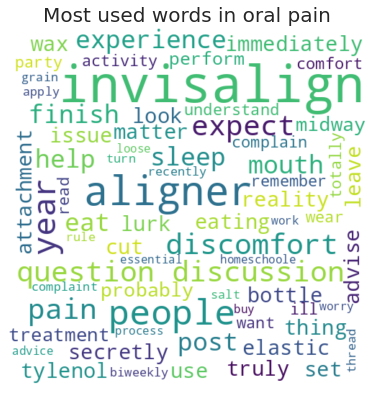

In [ ]:
#create_WordCloud(result['Lemma_text'].loc[result.Label == 'oral pain'], title="Most used words in oral pain")